In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import check_X_y
import time
from statistics import mean

In [2]:
%store -r dataset_pred_bc

In [3]:
dataset = dataset_pred_bc
dataset.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_name,cat1,inex1,clean_content,cat1_clean,target,predicted_bc
0,gp:AOqpTOF5UoM-6ovAjd8ULHKjifvZCeJyoJWi4F_IaPO...,Max Toon,https://play-lh.googleusercontent.com/a-/AOh14...,This is yhr best app ever im littetally addict...,5,0,18.1.3,2020-12-11 19:51:21,NaN,NaN,tiktok,addiction,internal,yhr app im littetally addict thing personally ...,addiction,1,1.0
2,gp:AOqpTOF1KZT5ggeQqGpl62-V6QzBxhROn0eutiZMm9l...,izzyiscool,https://play-lh.googleusercontent.com/a-/AOh14...,I love this app like im addicted,5,0,NaN,2020-10-12 1:38:54,NaN,NaN,tiktok,addiction,internal,love app im addict,addiction,1,1.0
3,gp:AOqpTOFRuZB5C5PEpW09xVx3pts_63bcWm9DFf4rajR...,Kristopher Lyons,https://play-lh.googleusercontent.com/a-/AOh14...,"This app allows pedophile acts, underage half ...",1,17,17.9.5,2020-12-03 9:55:01,NaN,NaN,tiktok,inappropriate content,internal,app pedophile act underage half naked girl ina...,inappropriate content,1,1.0
5,gp:AOqpTOEQ6a1gB6lPbUeoN88uBXzVwRwTKLfzTkAHVq8...,Nelly Muizniece,https://play-lh.googleusercontent.com/a-/AOh14...,I will NEVER delete this app EVER IT'S SO GOOD...,5,0,17.5.4,2020-12-10 17:51:15,NaN,NaN,tiktok,addiction,internal,delete app good download reccomend picky rat s...,addiction,1,1.0
6,gp:AOqpTOGlTe2kTFOBYaiP5SYp-9NZVm6xLmlG6H4TyfU...,Eddie Briz,https://play-lh.googleusercontent.com/-5ahM7oT...,This app is not real it should not be on or al...,1,0,NaN,2020-11-14 16:09:46,NaN,NaN,tiktok,inappropriate content,internal,app real allow app safe app kid adult,inappropriate content,1,1.0


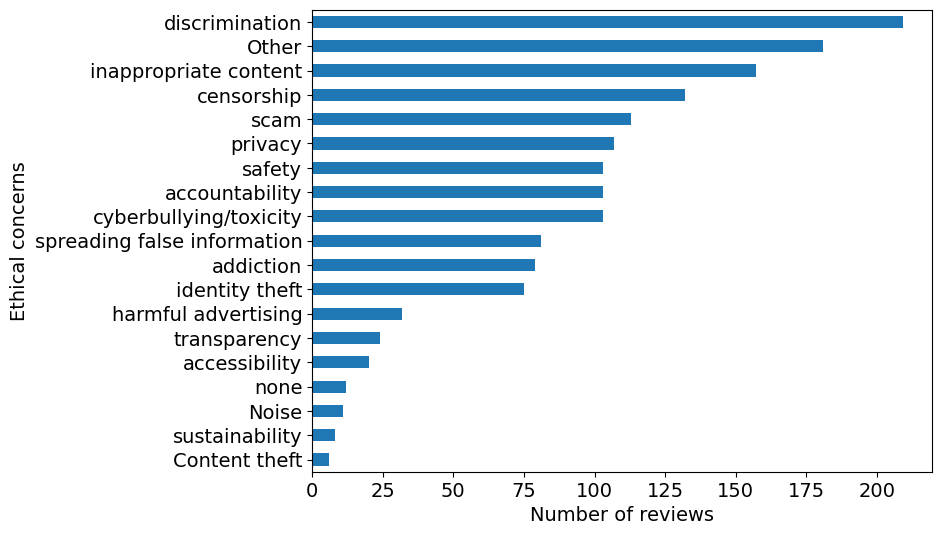

In [4]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

dataset.groupby('cat1').clean_content.count().sort_values(ascending=True).plot.barh(ylim=0, color='#1f77b4', ax=ax)
#plt.title('Frequency of Ethical concerns')

plt.xlabel('Number of reviews', fontsize=14)  # Increase font size to 12
plt.ylabel('Ethical concerns', fontsize=14)  # Increase font size to 12

# Increase font size of tick labels on both axes
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label font size to 10
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label font size to 10

plt.show()

In [5]:
dataset.groupby('cat1').clean_content.count().sort_values(ascending=True).to_csv('all_concern.csv')

In [6]:
def clean_no_concern(dataset):
    df = dataset[pd.notnull(dataset['clean_content'])]
    df = df.query("cat1 not in ['Other', 'none', 'Noise']")
    # get a function here to define top
    df_count = df.groupby('cat1').clean_content.count().reset_index(name='counts')
    top_list = df_count[df_count['counts'] > 50]['cat1']
    top_list = top_list.to_list()
    dataset = dataset.query("cat1  in @top_list")
    print(dataset.groupby('cat1').clean_content.count())
    return dataset

In [7]:
dataset = clean_no_concern(dataset)

cat1
accountability                 103
addiction                       79
censorship                     132
cyberbullying/toxicity         103
discrimination                 209
identity theft                  75
inappropriate content          157
privacy                        107
safety                         103
scam                           113
spreading false information     81
Name: clean_content, dtype: int64


In [9]:
def factorize_concern(dataset):
    dataset['cat1_id'] = dataset['cat1'].factorize()[0]
    concern_id_df = dataset[['cat1', 'cat1_id']].drop_duplicates().sort_values('cat1_id')
    concern_to_id = dict(concern_id_df.values)
    id_to_concern = dict(concern_id_df[['cat1_id', 'cat1']].values)
    return dataset, concern_id_df, concern_to_id, id_to_concern

In [10]:
dataset, concern_id_df, concern_to_id, id_to_concern = factorize_concern(dataset)

/var/folders/z5/8gb5zsq90kz9zvv3q5_7tkhw0000gn/T/ipykernel_52857/669406585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cat1_id'] = dataset['cat1'].factorize()[0]


In [11]:
concern_to_id

{'addiction': 0,
 'inappropriate content': 1,
 'privacy': 2,
 'discrimination': 3,
 'spreading false information': 4,
 'censorship': 5,
 'safety': 6,
 'identity theft': 7,
 'cyberbullying/toxicity': 8,
 'scam': 9,
 'accountability': 10}

In [12]:
dataset

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_name,cat1,inex1,clean_content,cat1_clean,target,predicted_bc,cat1_id
0,gp:AOqpTOF5UoM-6ovAjd8ULHKjifvZCeJyoJWi4F_IaPO...,Max Toon,https://play-lh.googleusercontent.com/a-/AOh14...,This is yhr best app ever im littetally addict...,5,0,18.1.3,2020-12-11 19:51:21,NaN,NaN,tiktok,addiction,internal,yhr app im littetally addict thing personally ...,addiction,1,1.0,0
2,gp:AOqpTOF1KZT5ggeQqGpl62-V6QzBxhROn0eutiZMm9l...,izzyiscool,https://play-lh.googleusercontent.com/a-/AOh14...,I love this app like im addicted,5,0,NaN,2020-10-12 1:38:54,NaN,NaN,tiktok,addiction,internal,love app im addict,addiction,1,1.0,0
3,gp:AOqpTOFRuZB5C5PEpW09xVx3pts_63bcWm9DFf4rajR...,Kristopher Lyons,https://play-lh.googleusercontent.com/a-/AOh14...,"This app allows pedophile acts, underage half ...",1,17,17.9.5,2020-12-03 9:55:01,NaN,NaN,tiktok,inappropriate content,internal,app pedophile act underage half naked girl ina...,inappropriate content,1,1.0,1
5,gp:AOqpTOEQ6a1gB6lPbUeoN88uBXzVwRwTKLfzTkAHVq8...,Nelly Muizniece,https://play-lh.googleusercontent.com/a-/AOh14...,I will NEVER delete this app EVER IT'S SO GOOD...,5,0,17.5.4,2020-12-10 17:51:15,NaN,NaN,tiktok,addiction,internal,delete app good download reccomend picky rat s...,addiction,1,1.0,0
6,gp:AOqpTOGlTe2kTFOBYaiP5SYp-9NZVm6xLmlG6H4TyfU...,Eddie Briz,https://play-lh.googleusercontent.com/-5ahM7oT...,This app is not real it should not be on or al...,1,0,NaN,2020-11-14 16:09:46,NaN,NaN,tiktok,inappropriate content,internal,app real allow app safe app kid adult,inappropriate content,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,gp:AOqpTOHKZVqOi833BqSbJVF5RuLcRFT5MP1rdGEq7LA...,Rain Shawn,https://play-lh.googleusercontent.com/-FqNg-r1...,My old acc was freaking reported and I cant ac...,1,0,NaN,2020-09-12 15:21:31,NaN,NaN,facebook,censorship,internal,acc freak report access report fake account us...,censorship,1,1.0,5
3061,gp:AOqpTOFi3_m8coYqfeTmF057lfeDO9KDOkYEYIJt5t6...,Michael Pate,https://play-lh.googleusercontent.com/a-/AOh14...,"I used Uber for years without any issues, but ...",1,30,4.284.10006,2019-10-19 17:50:09,"Hi Michael, we are sorry to hear that your acc...",2019-10-20 9:01:24,uber,accountability,internal,uber year issue recently make mistake app phon...,accountability,1,1.0,10
3073,gp:AOqpTOFV1PlG4cToSbtgqMc6CDZ1_dWKC3cjlrzvdTV...,Mel W.,https://play-lh.googleusercontent.com/a-/AOh14...,Due to the extreme difficulty of trying to con...,1,0,4.285.10004,2019-12-17 2:43:09,NaN,NaN,uber,accountability,internal,due extreme difficulty contact customer servic...,accountability,1,1.0,10
3086,gp:AOqpTOEjxZFJWLk92JAZ5YP85cBaVRy8a7hiCi9CZo0...,Jan Anthony,https://play-lh.googleusercontent.com/a-/AOh14...,If you lost your phone and cannot access your ...,1,1,4.209.10003,2020-07-26 2:17:39,NaN,NaN,uber,accountability,internal,lose phone access uber account email link emai...,accountability,1,1.0,10


In [13]:
def vectorizer(dataset):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
    features = tfidf.fit_transform(dataset.clean_content).toarray()
    labels = dataset.cat1_id
    print("features: ", features.shape)
    return  features, labels

In [14]:
features, labels = vectorizer(dataset)

features:  (1262, 815)


In [15]:
def add_predict(df, y_pred, indices_test):
    for ind, pred in zip(indices_test, y_pred):
        df.at[ind, "predicted"] = id_to_concern[int(pred)]
    return df

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score, cross_validate


modelRF = RandomForestClassifier(random_state=1,
                              bootstrap=False,
                              max_depth=150,
                              max_features='log2',
                              min_samples_leaf=1,
                              min_samples_split=0.0015,
#                               min_samples_split=0.475,
                              n_estimators=200)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, dataset.index,
                                                                                     test_size=0.33, random_state=0)

modelRF.fit(X_train, y_train)
y_pred = modelRF.predict(X_test)
print("predicted dataset length: ", len(indices_test))

predict_dataset = add_predict(dataset, y_pred, indices_test)

    

predicted dataset length:  417


/var/folders/z5/8gb5zsq90kz9zvv3q5_7tkhw0000gn/T/ipykernel_52857/2303982516.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[ind, "predicted"] = id_to_concern[int(pred)]


In [17]:
predict_dataset['clean_content'] = predict_dataset.clean_content.apply(lambda x: x.split(' '))
predict_dataset['clean_content']

/var/folders/z5/8gb5zsq90kz9zvv3q5_7tkhw0000gn/T/ipykernel_52857/1753803470.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_dataset['clean_content'] = predict_dataset.clean_content.apply(lambda x: x.split(' '))


0       [yhr, app, im, littetally, addict, thing, pers...
2                                 [love, app, im, addict]
3       [app, pedophile, act, underage, half, naked, g...
5       [delete, app, good, download, reccomend, picky...
6          [app, real, allow, app, safe, app, kid, adult]
                              ...                        
3055    [acc, freak, report, access, report, fake, acc...
3061    [uber, year, issue, recently, make, mistake, a...
3073    [due, extreme, difficulty, contact, customer, ...
3086    [lose, phone, access, uber, account, email, li...
3100    [caution, app, doesnt, delete, card, detail, b...
Name: clean_content, Length: 1262, dtype: object

In [18]:
predict_dataset['predicted'].unique()
predict_dataset = predict_dataset[pd.notnull(predict_dataset['predicted'])]
predict_dataset['predicted'].unique()

array(['addiction', 'inappropriate content', 'privacy', 'safety',
       'spreading false information', 'discrimination', 'identity theft',
       'cyberbullying/toxicity', 'censorship', 'accountability', 'scam'],
      dtype=object)

In [19]:
wrong_predictions = predict_dataset[predict_dataset['predicted'] != predict_dataset['cat1']]
print(wrong_predictions[['cat1', 'predicted']])

                             cat1       predicted
52    spreading false information          safety
70          inappropriate content  discrimination
74    spreading false information  discrimination
99                         safety         privacy
106         inappropriate content          safety
...                           ...             ...
2866       cyberbullying/toxicity          safety
2942                         scam  discrimination
2944               accountability  discrimination
3030                      privacy  accountability
3054               accountability  discrimination

[97 rows x 2 columns]


In [20]:
len(predict_dataset['predicted'])

417

In [21]:
%store predict_dataset

Stored 'predict_dataset' (DataFrame)


In [22]:
predict_dataset['predicted'].unique()

array(['addiction', 'inappropriate content', 'privacy', 'safety',
       'spreading false information', 'discrimination', 'identity theft',
       'cyberbullying/toxicity', 'censorship', 'accountability', 'scam'],
      dtype=object)

In [24]:
df_count = predict_dataset.groupby(['predicted', 'app_name']).clean_content.count().sort_values(ascending=False).reset_index(name='counts')
df_count.to_csv('predicted_concern_per_app.csv')

In [25]:
df_count

,predicted,app_name,counts
0,discrimination,tiktok,56
1,inappropriate content,tiktok,35
2,cyberbullying/toxicity,tiktok,34
3,safety,uber,28
4,censorship,facebook,21
...,...,...,...
59,discrimination,alexa,1
60,discrimination,googlehome,1
61,privacy,googlehome,1
62,inappropriate content,facebook,1


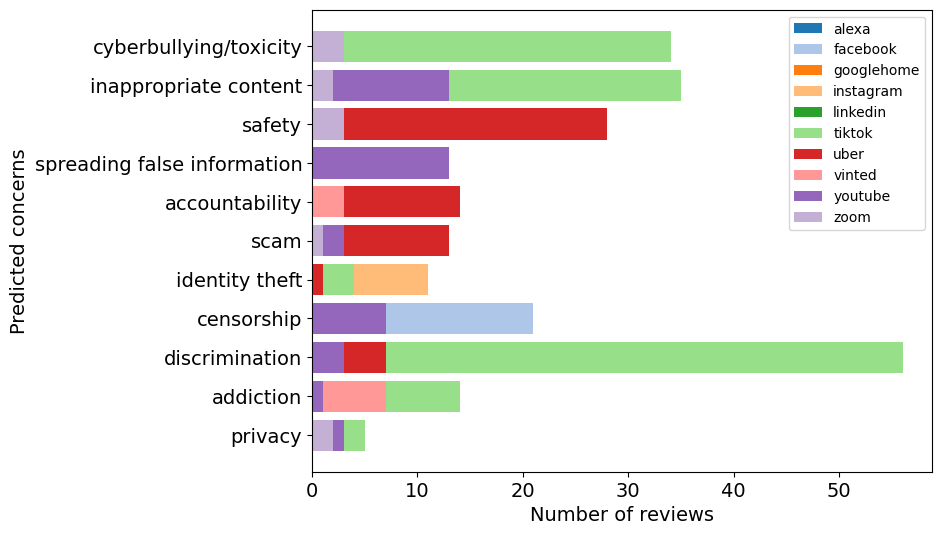

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named df_count with columns: predicted, app_name, and counts

# Group the DataFrame by app_name
grouped_df = df_count.groupby('app_name')

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figsize as needed
colors = sns.color_palette("tab20", len(df_count['app_name'].unique()))


for i, (group, data) in enumerate(grouped_df):
    ax.barh(data['predicted'], data['counts'], color=colors[i], label=group)

# Customize the plot

plt.xlabel('Number of reviews', fontsize=14)  # Increase font size to 12
plt.ylabel('Predicted concerns', fontsize=14)  # Increase font size to 12

# Increase font size of tick labels on both axes
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label font size to 10
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label font size to 10
ax.legend()

plt.xticks()  # Rotate x-axis labels if needed

# Show the plot
plt.show()


In [27]:
# Group the DataFrame by app_name
grouped_df = df_count.groupby('app_name')

print(grouped_df)

In [28]:
# Get the categories and sort them in ascending order based on total counts
categories = df_count['predicted'].unique()
total_counts = df_count.groupby('predicted')['counts'].sum().reset_index()
sorted_counts = total_counts.sort_values('counts')
sorted_categories = sorted_counts['predicted']


In [29]:
predict_dataset.groupby(['predicted','app_name']).clean_content.count()

predicted                    app_name  
accountability               facebook       3
                             googlehome     1
                             instagram      2
                             tiktok         8
                             uber          14
                                           ..
spreading false information  facebook       2
                             instagram      5
                             linkedin       1
                             tiktok         5
                             youtube       13
Name: clean_content, Length: 64, dtype: int64